[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/Bolin_1958/timescales_comparison.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/examples/PySDM_examples/Bolin_1958/timescales_comparison.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/Bolin_1958/timescales_comparison.ipynb)

#### Timescales comparison 






In [1]:
import sys

from PySDM.physics.constants import PER_CENT

if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [2]:
import numpy as np
from PySDM.physics import si, in_unit
from PySDM import Formulae
from open_atmos_jupyter_utils import show_plot
import pandas as pd
from matplotlib import pyplot

In [3]:
any_non_zero_value = 44.0
radii_bolin = np.asarray([0.005, 0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.20]) * si.cm
radii = np.linspace(0.005, 0.2) * si.cm
temperature = Formulae().constants.T0 + 10 * si.K
settings = {
    "terminal_velocity":"RogersYau",
    "particle_shape_and_density":"LiquidSpheres",
    "isotope_equilibrium_fractionation_factors":"VanHook1968",
    "isotope_diffusivity_ratios":"HellmannAndHarvey2020",
    "isotope_relaxation_timescale": "ZabaAndArabas2025",
}

In [4]:
formulae = Formulae(**settings)
const = formulae.constants
p = const.p_STP
D = formulae.diffusion_thermics.D(temperature, p)
K = formulae.diffusion_thermics.K(temperature, p)
lv = formulae.latent_heat_vapourisation.lv(temperature)
eta_air = formulae.air_dynamic_viscosity.eta_air(temperature)
air_density = p/const.Rd/temperature
v_term = formulae.terminal_velocity.v_term(radii)
Re = formulae.particle_shape_and_density.reynolds_number(
    radius=radii,
    velocity_wrt_air=v_term,
    dynamic_viscosity=eta_air,
    density=air_density,
)
Sc = formulae.trivia.air_schmidt_number(
    dynamic_viscosity=eta_air,
    diffusivity=D,
    density=air_density,
)
sqrt_re_times_cbrt_sc = formulae.trivia.sqrt_re_times_cbrt_sc(Re, Sc)
f = formulae.ventilation.ventilation_coefficient(sqrt_re_times_cbrt_sc)


In [5]:
adjustment_time = {
    "Bolin's table": np.asarray([3.3, 7.1, 33, 93, 165, 245, 365, 435]) * si.s,
}

In [6]:
isotopes = ('2H', '18O', '17O')
isotopes_attr = {
    'diff_iso': {isotope: getattr(formulae.isotope_diffusivity_ratios, f'ratio_{isotope}')(temperature) * D for isotope in isotopes},
    'alpha_l': {isotope: getattr(formulae.isotope_equilibrium_fractionation_factors, f'alpha_l_{isotope}')(temperature) for isotope in isotopes},
    'R_liq': {isotope: getattr(const, f'VSMOW_R_{isotope}') for isotope in isotopes},
    'ventilation': {isotope: f for isotope in isotopes}
}
S = 0
R_vap = .00003
rho_s=const.rho_w
def timescale(isotope, S, R_vap):
    m_dm_dt = formulae.isotope_relaxation_timescale.isotope_m_dm_dt(
        rho_s=rho_s,
        radius=radii,
        D_iso=isotopes_attr['diff_iso'][isotope],
        D=D,
        S=S,
        R_liq=isotopes_attr['R_liq'][isotope],
        alpha=isotopes_attr['alpha_l'][isotope],
        R_vap=R_vap,
        Fk=formulae.drop_growth.Fk(temperature, K, lv)
    )
    return formulae.isotope_relaxation_timescale.tau(m_dm_dt)

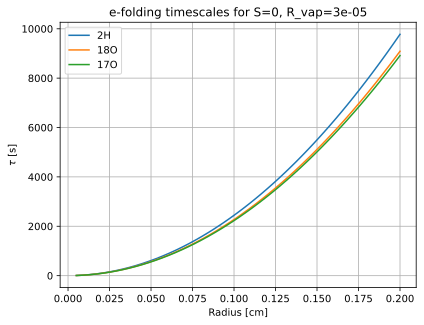

In [7]:
for isotope in isotopes:
    pyplot.plot(in_unit(radii, si.cm), timescale(
        isotope=isotope,
        S=S,
        R_vap=R_vap
    ), label=isotope)
pyplot.gca().set(
    title=f'e-folding timescales for S={S}, R_vap={R_vap}',
    xlabel='Radius [cm]',
    ylabel='$\\tau$ [s]',
)
pyplot.legend()
pyplot.grid()
show_plot('fig_isotopes')

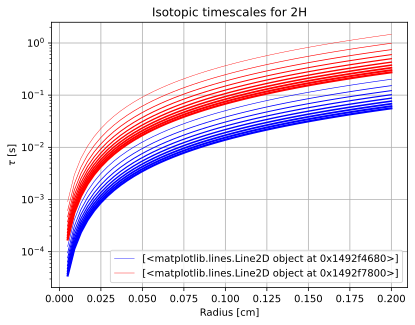

In [102]:
iso = '2H'
fig, ax = pyplot.subplots()
for S in np.linspace(0.2, 1.07, 10):
    p1 = ax.plot(in_unit(radii, si.cm), timescale(isotope=iso, S=S, R_vap=R_vap), 'b', linewidth=2*S, label='2H')
    p2 = ax.plot(in_unit(radii, si.cm), timescale(isotope='17O', S=S, R_vap=R_vap), 'r', linewidth=2*S, label='17O')
    ax.legend((p1, p2))
ax.set(
    title=f'Isotopic timescales for {iso}',
    xlabel='Radius [cm]',
    ylabel='$\\tau$ [s]',
    yscale='log',
)
ax.grid()
show_plot('fig_timescales_S')

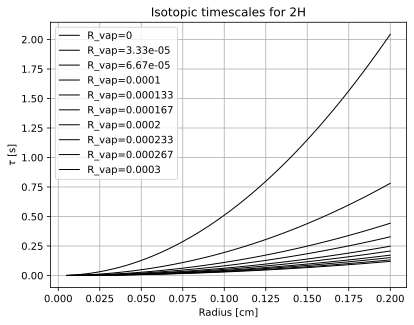

In [46]:
iso = '2H'
for R_vap in np.linspace(0, 0.03, 10) * PER_CENT:
    pyplot.plot(in_unit(radii, si.cm), timescale(isotope=iso, S=0.5, R_vap=R_vap), 'k', linewidth=1+R_vap, label=f'{R_vap=:.3g}')
pyplot.gca().set(
    title=f'Isotopic timescales for {iso}',
    xlabel='Radius [cm]',
    ylabel='$\\tau$ [s]',
)
pyplot.legend()
pyplot.grid()
show_plot('fig_timescales_R_vap')

/var/folders/gl/1t3c1h9x3ws6d68b11gr2rth0000gn/T/ipykernel_59812/2317903483.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  pyplot.legend()


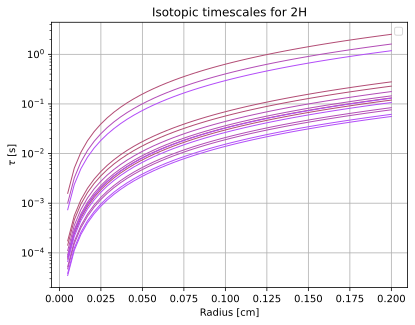

In [76]:
for S in np.linspace(0.5, 1.07, 3):
    for R_vap in np.linspace(0, 0.03, 5) * PER_CENT:
        pyplot.plot(in_unit(radii, si.cm), timescale(isotope=iso, S=S, R_vap=R_vap), linewidth=1+10*R_vap, color=(.7,.3,S/1.1))
pyplot.gca().set(
    title=f'Isotopic timescales for {iso}',
    xlabel='Radius [cm]',
    ylabel='$\\tau$ [s]',
    yscale='log',
)
pyplot.legend()
pyplot.grid()
show_plot('fig_timescales_R_vap')
    